In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import geopandas as gpd
import rasterio as rio

In [3]:
pwd

'C:\\Users\\musimundo\\Desktop\\coco_coding_homework-main\\coco_coding_homework-main\\coco_coding_homework\\GeoHackeo\\buenos_aires-master\\buenos_aires-master'

# descripcion inicial del dataset
Este proyecto va a trabajar con un dataset de temperaturas minimas y maximas durante 365dias de todas las estaciones pertenecientes al Servicio Meteorologico Nacional Argentino. 
El objetivo es limpiar el dataset para quedarnos con 5 estaciones que generan un "perfil" desde zonas menos a mas urbanizadas.

In [4]:
# Importo los datos de temperatura
data_folder = Path(".") 
dataset_temperatura = pd.read_csv (data_folder / 'temperatura365d_todo.csv', sep= ";")

In [5]:
dataset_temperatura.head()

FECHA  TMAX  TMIN             NOMBRE
0         NaN   NaN   NaN                NaN
1  15032023.0  30.6  24.5    AEROPARQUE AERO
2  15032023.0  28.5  19.9          AZUL AERO
3  15032023.0  32.3  21.2  BAHIA BLANCA AERO
4  15032023.0  19.4  11.5     BARILOCHE AERO

A primera vista se observa que la columna fecha no esta en un formato aceptable, y que hay datos NaN, por lo que es necesario realizar algunos cambios en la columna fecha.
Es necesario:
1- eliminar la terminacion ".0"
2- no sabemos si las fechas que comienzan en dias de 1 digito digamos 9 de marzo de 2023 estan escritas como 09/03/2023 o 9/03/2023, es necesario corregir esto o estar seguro de que vamos a tener siempre 8 digitos en la fecha para una posterior conversion

In [6]:
# Para poder elimiar una parte de un dato, pandas sugiere trabajar con str, por lo que transformamos la columna FECHA en str
dataset_temperatura["FECHA"]= dataset_temperatura["FECHA"].astype(str)

In [7]:
# luego tomamos todos los datos de temperatura y les eliminamos los ultimos 2 digitos 
dataset_temperatura["FECHA"] = dataset_temperatura["FECHA"].str.slice(stop=-2)

In [8]:
# para evitar posibles errores de formato, se utiliza zfill(), este codigo lo que hace es agregar 0 al inicio del dato
# hasta llegar a lenght= 8, en el caso de que el dato ya tenga 8 digitos, no hace nada.. el objetivo de esto es 
# que en el caso que existan fechas escritas como 9032023, la va a convertir a 09032023, y asi evitar futuros errores
dataset_temperatura["FECHA"] = dataset_temperatura["FECHA"].str.zfill(8)

In [9]:
dataset_temperatura

FECHA  TMAX  TMIN                       NOMBRE
0      0000000n   NaN   NaN                          NaN
1      15032023  30.6  24.5              AEROPARQUE AERO
2      15032023  28.5  19.9                    AZUL AERO
3      15032023  32.3  21.2            BAHIA BLANCA AERO
4      15032023  19.4  11.5               BARILOCHE AERO
...         ...   ...   ...                          ...
44352  16032022  35.7  14.3                  VIEDMA AERO
44353  16032022  31.7  14.3  VILLA DE MARIA DEL RIO SECO
44354  16032022  34.3  19.2           VILLA DOLORES AERO
44355  16032022  30.3  10.4            VILLA GESELL AERO
44356  16032022  36.2   9.6          VILLA REYNOLDS AERO

[44357 rows x 4 columns]

Ahora el dataset tiene un formato mas aceptable, con todos los datos en la columna FECHA, normalizados. El siguiente paso es limpiar la base de datos, ya que se ve a simple vista que hay datos NaNs

In [10]:
# buscamos si hay datos null
dataset_temperatura.isnull()

FECHA   TMAX   TMIN  NOMBRE
0      False   True   True    True
1      False  False  False   False
2      False  False  False   False
3      False  False  False   False
4      False  False  False   False
...      ...    ...    ...     ...
44352  False  False  False   False
44353  False  False  False   False
44354  False  False  False   False
44355  False  False  False   False
44356  False  False  False   False

[44357 rows x 4 columns]

In [11]:
# eliminamos los datos null
dataset_temperatura = dataset_temperatura.dropna()

In [12]:
#buscamos datos duplicados
dataset_temperatura[dataset_temperatura.duplicated()]

Empty DataFrame
Columns: [FECHA, TMAX, TMIN, NOMBRE]
Index: []

In [13]:
dataset_temperatura.shape

(42165, 4)

Se han eliminado mas de 2000 filas que tenian datos NaN.
El siguiente paso es tranformar el dato en la columna FECHA en formato Fecha

In [14]:
# redefinimos la columna FECHA asignandole un formato, en este caso le decimos que los 2 primeros digitos son dia
# los digitos 3-4 son el mes y los ultimos 4 son el año 
dataset_temperatura["FECHA"]= pd.to_datetime(dataset_temperatura["FECHA"], format='%d%m%Y')

C:\Users\musimundo\AppData\Local\Temp\ipykernel_21060\1840762363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_temperatura["FECHA"]= pd.to_datetime(dataset_temperatura["FECHA"], format='%d%m%Y')


In [15]:
# el codigo tira un error, pero luego cuando inscpeccionamos el dataset, vemos que la columna fecha fue formateada con exito
dataset_temperatura

FECHA  TMAX  TMIN                       NOMBRE
1     2023-03-15  30.6  24.5              AEROPARQUE AERO
2     2023-03-15  28.5  19.9                    AZUL AERO
3     2023-03-15  32.3  21.2            BAHIA BLANCA AERO
4     2023-03-15  19.4  11.5               BARILOCHE AERO
5     2023-03-15  -6.0 -13.7             BASE BELGRANO II
...          ...   ...   ...                          ...
44352 2022-03-16  35.7  14.3                  VIEDMA AERO
44353 2022-03-16  31.7  14.3  VILLA DE MARIA DEL RIO SECO
44354 2022-03-16  34.3  19.2           VILLA DOLORES AERO
44355 2022-03-16  30.3  10.4            VILLA GESELL AERO
44356 2022-03-16  36.2   9.6          VILLA REYNOLDS AERO

[42165 rows x 4 columns]

AEROPARQUE AERO
BUENOS AIRES
EL PALOMAR AERO
MORON AERO
MERLO AERO
NUEVE DE JULIO

In [16]:
#, dataset_temperatura['NOMBRE']== 'BUENOS AIRES'
#                     , dataset_temperatura['NOMBRE']== 'EL PALOMAR AERO'
 #                    , dataset_temperatura['NOMBRE']== 'MORON AERO'
 #                    , dataset_temperatura['NOMBRE']== 'MERLO AERO'
  #                   , dataset_temperatura['NOMBRE']== 'NUEVE DE JULIO')

In [17]:
filtro_aeroparque = dataset_temperatura['NOMBRE']== 'AEROPARQUE AERO' 
filtro_palomar = dataset_temperatura['NOMBRE']== 'EL PALOMAR AERO'
filtro_moron = dataset_temperatura['NOMBRE']== 'MORON AERO'
filtro_9_julio = dataset_temperatura['NOMBRE']== 'NUEVE DE JULIO'


In [18]:
#Alternativa
#rows = []
#for index, row in data.iterrows():
#    if row['NOMBRE'] == 'AEROPARQUE AERO' or row['NOMBRE'] == 'BUENOS AIRES OBSERVATORIO' or row['NOMBRE'] == 'EL PALOMAR AERO' or row['NOMBRE'] == 'BUENOS AIRES' or row['NOMBRE'] == 'MORON AERO' or row['NOMBRE'] == 'MERLO AERO' or row['NOMBRE'] == 'NUEVE DE JULIO' :
#        rows.append(row)
    

In [19]:
estaciones_target = (filtro_aeroparque + filtro_palomar  + filtro_moron
                + filtro_9_julio)
estaciones = dataset_temperatura[estaciones_target]

In [20]:
estaciones

FECHA  TMAX  TMIN           NOMBRE
1     2023-03-15  30.6  24.5  AEROPARQUE AERO
33    2023-03-15  30.8  24.2  EL PALOMAR AERO
64    2023-03-15  31.4  25.9       MORON AERO
66    2023-03-15  32.6  21.8   NUEVE DE JULIO
123   2023-03-14  35.1  27.4  AEROPARQUE AERO
...          ...   ...   ...              ...
44179 2022-03-17  30.8  15.6   NUEVE DE JULIO
44235 2022-03-16  27.6  19.8  AEROPARQUE AERO
44267 2022-03-16  28.9  15.0  EL PALOMAR AERO
44299 2022-03-16  28.8  19.5       MORON AERO
44301 2022-03-16  30.1  18.1   NUEVE DE JULIO

[1459 rows x 4 columns]

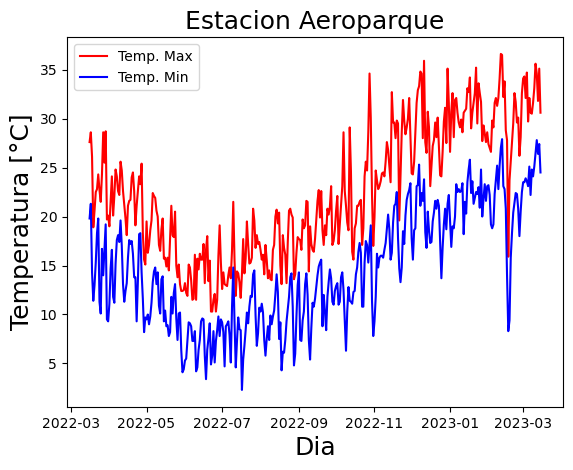

In [24]:
plt.plot (dataset_temperatura[filtro_aeroparque].FECHA , dataset_temperatura[filtro_aeroparque].TMAX, linestyle="-", 
          color = 'red', label= "Temp. Max")
plt.plot (dataset_temperatura[filtro_aeroparque].FECHA , dataset_temperatura[filtro_aeroparque].TMIN, linestyle="-", 
          color = 'blue', label= "Temp. Min")
plt.legend()
plt.ylabel('Temperatura [°C]',fontsize=18)
plt.xlabel('Dia',fontsize=18)
plt.title('Estacion Aeroparque',fontsize=18)
plt.show()

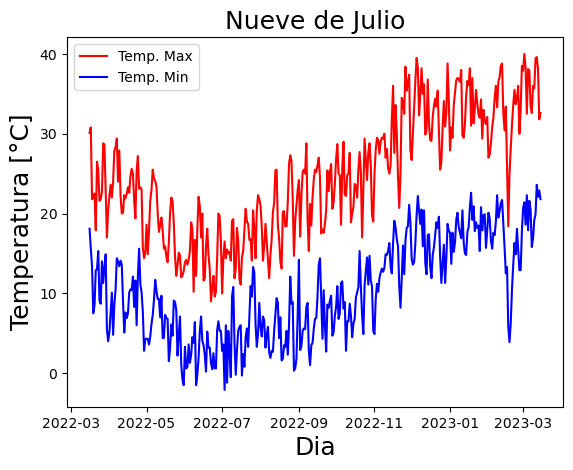

In [25]:
plt.plot (dataset_temperatura[filtro_9_julio].FECHA , dataset_temperatura[filtro_9_julio].TMAX, linestyle="-", 
          color = 'red', label= "Temp. Max")
plt.plot (dataset_temperatura[filtro_9_julio].FECHA , dataset_temperatura[filtro_9_julio].TMIN, linestyle="-", 
          color = 'blue', label= "Temp. Min")
plt.legend()
plt.ylabel('Temperatura [°C]',fontsize=18)
plt.xlabel('Dia',fontsize=18)
plt.title('Nueve de Julio',fontsize=18)
plt.show()

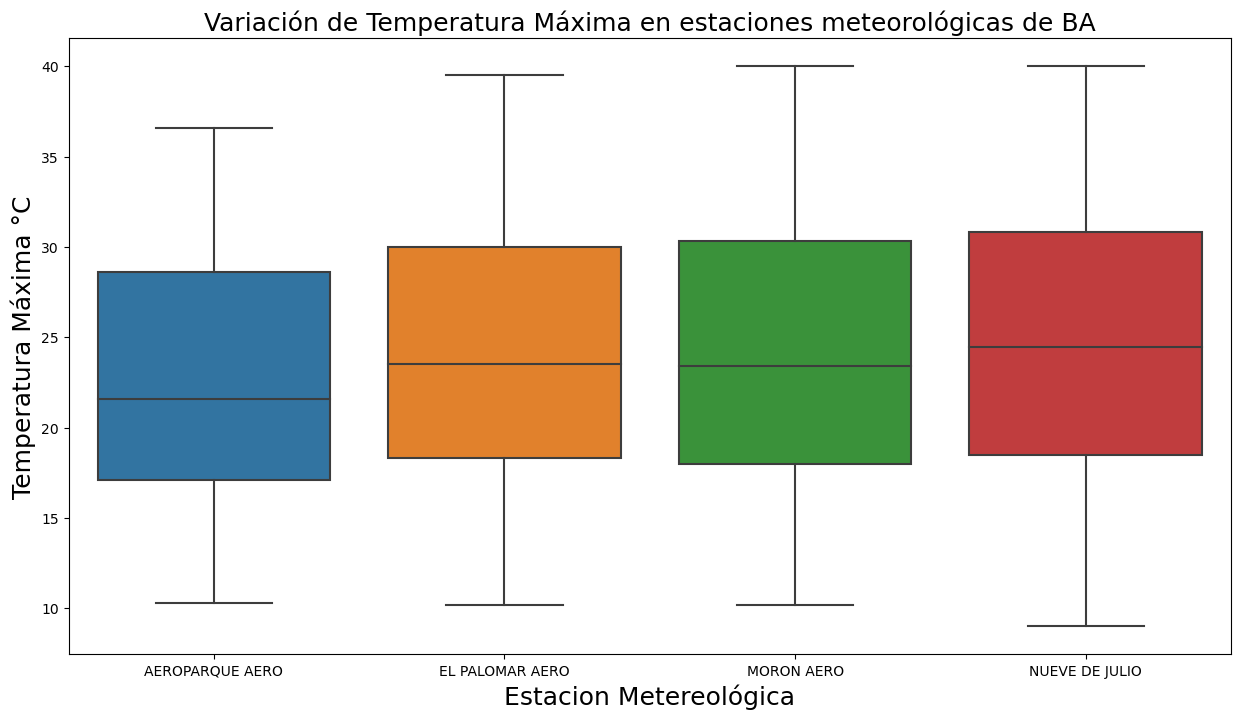

In [28]:
import seaborn as sns
plt.figure(figsize=(15,8))

ax = sns.boxplot(data= estaciones , x="NOMBRE", y="TMAX")
ax.set_title('Variación de Temperatura Máxima en estaciones meteorológicas de BA',fontdict={'size': 18})

ax.set_xlabel('Estacion Metereológica', fontdict={'size': 18})
ax.set_ylabel('Temperatura Máxima °C', fontdict={'size': 18})

plt.show()

In [29]:
#Para separar solo las estaciones metereologicas que queremos 
stations=dataset_temperatura.loc[(dataset_temperatura['NOMBRE']=="AEROPARQUE AERO")| (dataset_temperatura['NOMBRE']=="BUENOS AIRES OBSERVATORIO")|(dataset_temperatura['NOMBRE']=="EL PALOMAR AERO")|(dataset_temperatura['NOMBRE']=="MERLO AERO")|(dataset_temperatura['NOMBRE']=="MORON AERO")|(dataset_temperatura['NOMBRE']=="NUEVE DE JULIO")]
stations.to_csv('stations.csv')
stations.head(20
             )

FECHA  TMAX  TMIN                     NOMBRE
1   2023-03-15  30.6  24.5            AEROPARQUE AERO
14  2023-03-15  30.6  26.6  BUENOS AIRES OBSERVATORIO
33  2023-03-15  30.8  24.2            EL PALOMAR AERO
64  2023-03-15  31.4  25.9                 MORON AERO
66  2023-03-15  32.6  21.8             NUEVE DE JULIO
123 2023-03-14  35.1  27.4            AEROPARQUE AERO
136 2023-03-14  37.0  27.6  BUENOS AIRES OBSERVATORIO
155 2023-03-14  37.0  26.9            EL PALOMAR AERO
186 2023-03-14  37.0  26.8                 MORON AERO
188 2023-03-14  31.8  22.9             NUEVE DE JULIO
245 2023-03-13  31.8  26.4            AEROPARQUE AERO
258 2023-03-13  35.0  27.0  BUENOS AIRES OBSERVATORIO
277 2023-03-13  35.5  26.6            EL PALOMAR AERO
308 2023-03-13  35.8  27.1                 MORON AERO
310 2023-03-13  38.1  22.1             NUEVE DE JULIO
367 2023-03-12  34.6  27.8            AEROPARQUE AERO
380 2023-03-12  36.5  28.0  BUENOS AIRES OBSERVATORIO
399 2023-03-12  37.0  26.5            EL PALOMAR AERO
430 2023-03-12  37.6  27.8                 MORON AERO
432 2023-03-12  39.6  23.6             NUEVE DE JULIO

In [30]:
# creamos una columna de T_average para todas las estaciones (6)
stations["T_AVE"] = (stations['TMAX'] + stations['TMIN'])/2
stations = stations.reindex(columns=['FECHA','TMAX','TMIN','T_AVE','NOMBRE'])
stations.head(6)

#dio error pero funcionó

C:\Users\musimundo\AppData\Local\Temp\ipykernel_21060\1955180816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations["T_AVE"] = (stations['TMAX'] + stations['TMIN'])/2


FECHA  TMAX  TMIN  T_AVE                     NOMBRE
1   2023-03-15  30.6  24.5  27.55            AEROPARQUE AERO
14  2023-03-15  30.6  26.6  28.60  BUENOS AIRES OBSERVATORIO
33  2023-03-15  30.8  24.2  27.50            EL PALOMAR AERO
64  2023-03-15  31.4  25.9  28.65                 MORON AERO
66  2023-03-15  32.6  21.8  27.20             NUEVE DE JULIO
123 2023-03-14  35.1  27.4  31.25            AEROPARQUE AERO

In [31]:
#Grupos por estaciones de trabajo (6) LO HACEMOS PARA CADA UNA DE LAS 6 ESTACIONES Y CON LAS FECHAS VOLTEADAS DE 
#MENOR A MAYOR: station1, station2, station3, station4,...station6

#Grupos por estaciones de trabajo (6): station1, station2, station3, station4,...station6
station1=stations.loc[stations['NOMBRE']=="AEROPARQUE AERO"]#.to_csv("station1p.csv")
station1
station1.to_csv("station1.csv") # pero cuando llamaosa la station1p, sale con un index al lado de la fecha

station2=stations.loc[stations['NOMBRE']=="BUENOS AIRES OBSERVATORIO"]
station2
station2.to_csv("station2.csv") # pero cuando llamaosa la station1p, sale con un index al lado de la fecha

station3=stations.loc[stations['NOMBRE']=="EL PALOMAR AERO"]
station3
station3.to_csv("station3.csv") # pero cuando llamaosa la station1p, sale con un index al lado de la fecha

station4=stations.loc[stations['NOMBRE']=="MORON AERO"]
station4
station4.to_csv("station4.csv") # pero cuando llamaosa la station1p, sale con un index al lado de la fecha

station5=stations.loc[stations['NOMBRE']=="NUEVE DE JULIO"]
station5
station5.to_csv("station5.csv") # pero cuando llamaosa la station1p, sale con un index al lado de la fecha
station4

FECHA  TMAX  TMIN  T_AVE      NOMBRE
64    2023-03-15  31.4  25.9  28.65  MORON AERO
186   2023-03-14  37.0  26.8  31.90  MORON AERO
308   2023-03-13  35.8  27.1  31.45  MORON AERO
430   2023-03-12  37.6  27.8  32.70  MORON AERO
552   2023-03-11  40.0  26.0  33.00  MORON AERO
...          ...   ...   ...    ...         ...
43813 2022-03-20  21.6   9.9  15.75  MORON AERO
43933 2022-03-19  20.5   6.4  13.45  MORON AERO
44055 2022-03-18  25.2  14.7  19.95  MORON AERO
44177 2022-03-17  30.9  19.4  25.15  MORON AERO
44299 2022-03-16  28.8  19.5  24.15  MORON AERO

[365 rows x 5 columns]

In [32]:
# read the datasets y CREAR UN TABLA DE TODAS LAS ESTACIONES (6) POR GRUPOS UNO DEBAJO DEL OTRO
a = pd.read_csv(r"station1.csv")
b = pd.read_csv(r"station2.csv")
c = pd.read_csv(r"station3.csv")
d = pd.read_csv(r"station4.csv")
e = pd.read_csv(r"station5.csv")
# print the datasets
#print(a.head())
#print(b.head())
#print(c.head())
#print(d.head())
#print(e.head())
#print(f.head())

Cinco_Est_ord = pd.concat([a, b, c, d, e], ignore_index=True)
Cinco_Est_ord.sort_values("Unnamed: 0", axis = 0, ascending = False,
                 inplace = True)
#Eliminando la columna Unnamed de station1: llamamos al file enc aso de hacerlo en otro momento...
#station6 = pd.read_csv('station6.csv')
# If you know the name of the column skip this
Unnamed = Cinco_Est_ord.columns[0]
Cinco_Est_ord = Cinco_Est_ord.drop([Unnamed], axis=1)
print(Cinco_Est_ord)

Cinco_Est_ord.to_csv('Cinco_Est_ord.csv')

           FECHA  TMAX  TMIN  T_AVE                     NOMBRE
1823  2022-03-16  30.1  18.1  24.10             NUEVE DE JULIO
1459  2022-03-16  28.8  19.5  24.15                 MORON AERO
1094  2022-03-16  28.9  15.0  21.95            EL PALOMAR AERO
729   2022-03-16  28.7  20.5  24.60  BUENOS AIRES OBSERVATORIO
364   2022-03-16  27.6  19.8  23.70            AEROPARQUE AERO
...          ...   ...   ...    ...                        ...
1460  2023-03-15  32.6  21.8  27.20             NUEVE DE JULIO
1095  2023-03-15  31.4  25.9  28.65                 MORON AERO
730   2023-03-15  30.8  24.2  27.50            EL PALOMAR AERO
365   2023-03-15  30.6  26.6  28.60  BUENOS AIRES OBSERVATORIO
0     2023-03-15  30.6  24.5  27.55            AEROPARQUE AERO

[1824 rows x 5 columns]


In [33]:
#SACAMOS    P R O M E D I O S   DE LOS VALORES DE TEMPERATURA PARA CADA MES DISPONIBLE DE 2022 Y 2023 PARA CADA ESTACION
a=station1.groupby(["NOMBRE", "FECHA"]).TMAX.mean()
#a
b=station1.groupby(["NOMBRE", "FECHA"]).TMIN.mean()
#b
c=station1.groupby(["NOMBRE", "FECHA"]).T_AVE.mean()
#c
#display(a, b,c)
#merge data
ab=pd.merge(a, b, on='FECHA')
ab
abc=pd.merge(ab, c, on='FECHA')
abc=abc.assign(NOMBRE='AEROPARQUE AERO')
print(abc)

            TMAX  TMIN  T_AVE           NOMBRE
FECHA                                         
2022-03-16  27.6  19.8  23.70  AEROPARQUE AERO
2022-03-17  28.6  21.3  24.95  AEROPARQUE AERO
2022-03-18  26.1  14.3  20.20  AEROPARQUE AERO
2022-03-19  18.9  11.4  15.15  AEROPARQUE AERO
2022-03-20  20.6  13.0  16.80  AEROPARQUE AERO
...          ...   ...    ...              ...
2023-03-11  35.6  26.5  31.05  AEROPARQUE AERO
2023-03-12  34.6  27.8  31.20  AEROPARQUE AERO
2023-03-13  31.8  26.4  29.10  AEROPARQUE AERO
2023-03-14  35.1  27.4  31.25  AEROPARQUE AERO
2023-03-15  30.6  24.5  27.55  AEROPARQUE AERO

[365 rows x 4 columns]


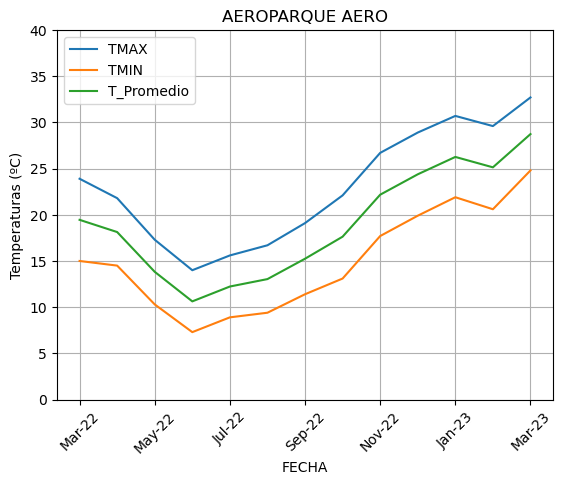

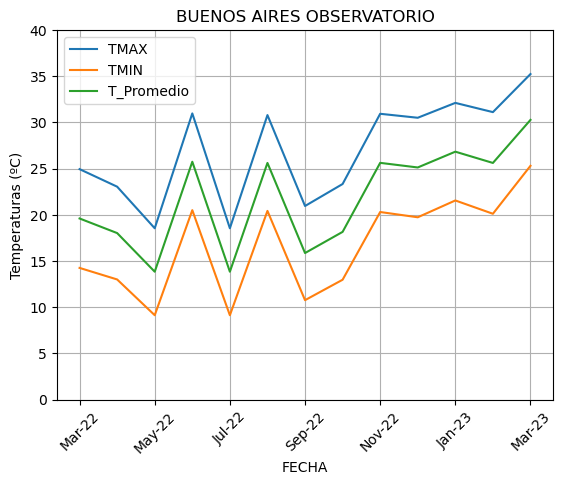

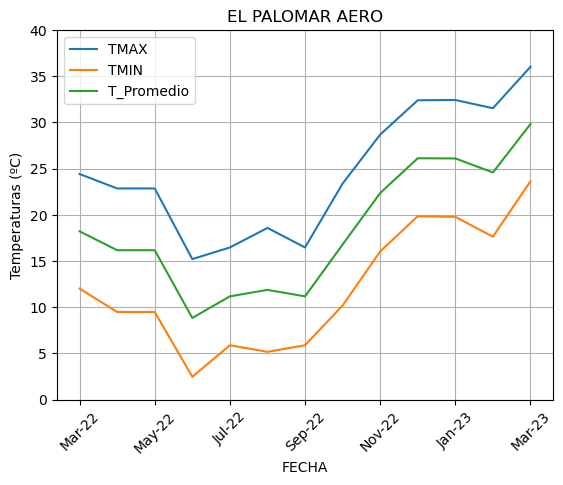

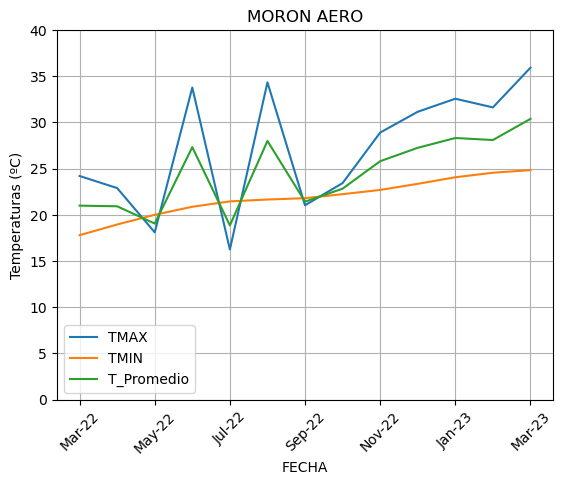

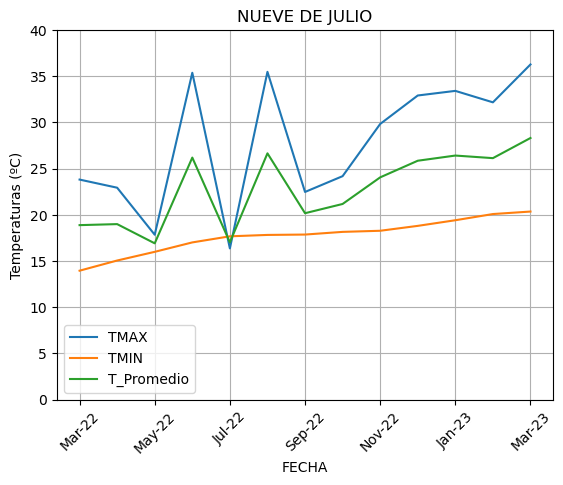

In [34]:
#CREAMOS GRAFICAS DE LINEAS CON TMAX, TMIN, T_AVE PARA CADA ESTACION, BASADOS EN LOS ARCHIVOS CSV DE PROMEDIOS POR ESTACION 
#station1_Ave.csv...station6_Ave.csv

station1= pd.read_csv('station1_Avg.csv')
#Rename heads
station1=station1.rename(columns={"T_AVE":"T_Promedio"})
#graphs
station1.plot('FECHA'), plt.ylabel ("Temperaturas (ºC)"),plt.title("AEROPARQUE AERO"), plt.ylim([0,40]), plt.grid(), plt.xticks(rotation=45), plt.gca().invert_xaxis(), 
plt.savefig("station1_Avg.png", dpi=300)

station2= pd.read_csv('station2_Avg.csv')
#Rename heads
station2=station2.rename(columns={"T_AVE":"T_Promedio"})
#graphs
station2.plot('FECHA'), plt.ylabel ("Temperaturas (ºC)"),plt.title("BUENOS AIRES OBSERVATORIO"), plt.ylim([0,40]), plt.grid(), plt.xticks(rotation=45), plt.gca().invert_xaxis(), 
plt.savefig("station2_Avg.png", dpi=300)

station3= pd.read_csv('station3_Avg.csv')
#Rename heads
station3=station3.rename(columns={"T_AVE":"T_Promedio"})
#graphs
station3.plot('FECHA'), plt.ylabel ("Temperaturas (ºC)"),plt.title("EL PALOMAR AERO"), plt.ylim([0,40]), plt.ylim([0,40]), plt.grid(), plt.xticks(rotation=45), plt.gca().invert_xaxis(), 
plt.savefig("station3_Avg.png", dpi=300)

station4= pd.read_csv('station4_Avg.csv')
#Rename heads
station4=station4.rename(columns={"T_AVE":"T_Promedio"})
#graphs
station4.plot('FECHA'), plt.ylabel ("Temperaturas (ºC)"),plt.title("MORON AERO"), plt.ylim([0,40]), plt.grid(), plt.xticks(rotation=45), plt.gca().invert_xaxis(), 
plt.savefig("station5_Avg.png", dpi=300)

station5= pd.read_csv('station5_Avg.csv')
#Rename heads
station5=station5.rename(columns={"T_AVE":"T_Promedio"})
#graphs
station5.plot('FECHA'), plt.ylabel ("Temperaturas (ºC)"),plt.title("NUEVE DE JULIO"), plt.ylim([0,40]), plt.grid(), plt.xticks(rotation=45), plt.gca().invert_xaxis(), 
plt.savefig("station5_Avg.png", dpi=300)

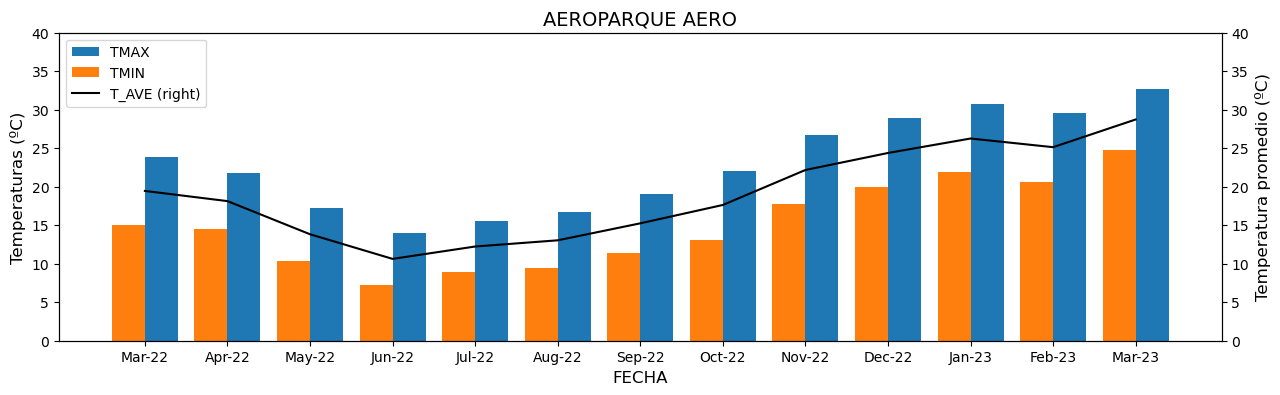

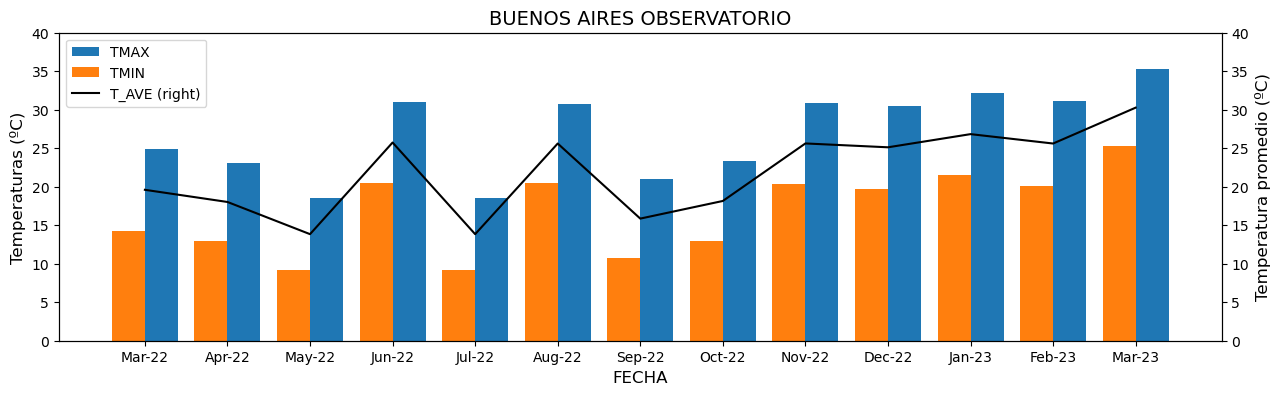

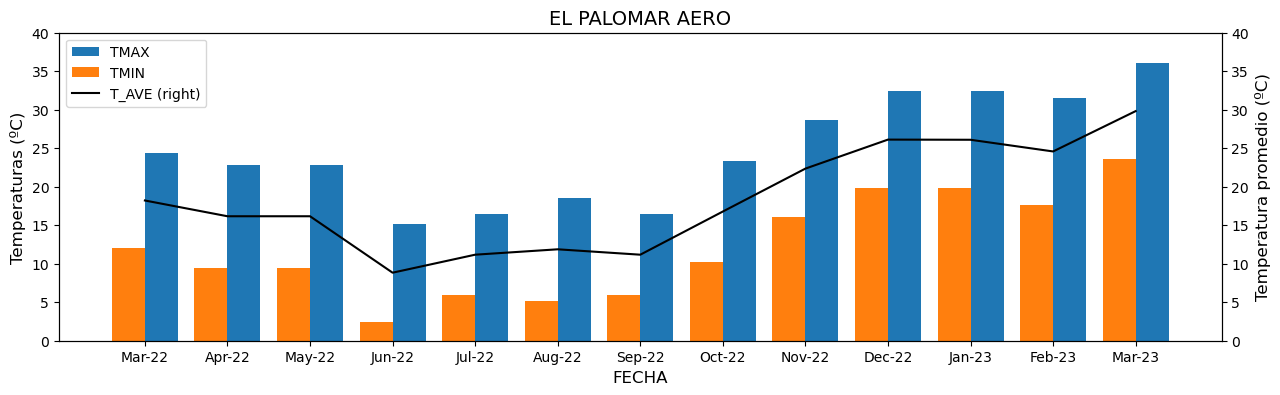

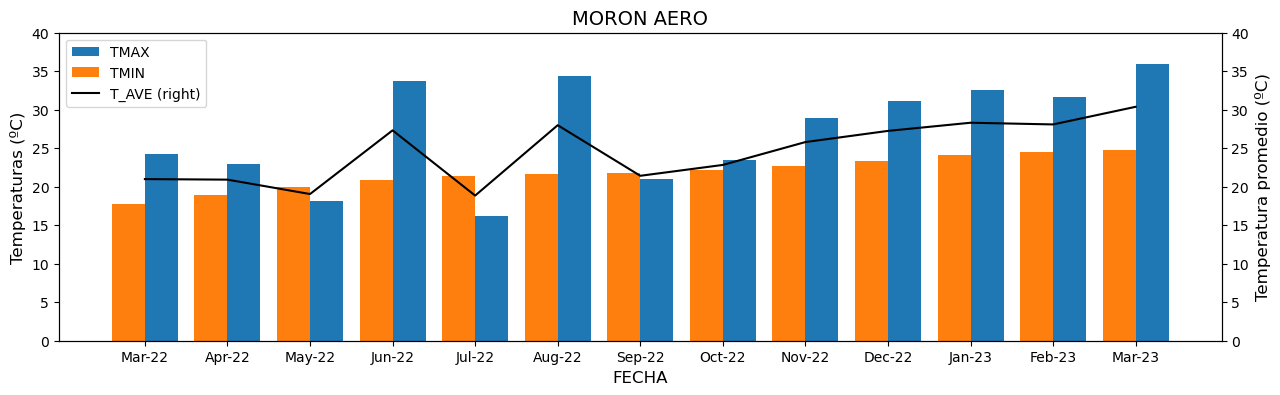

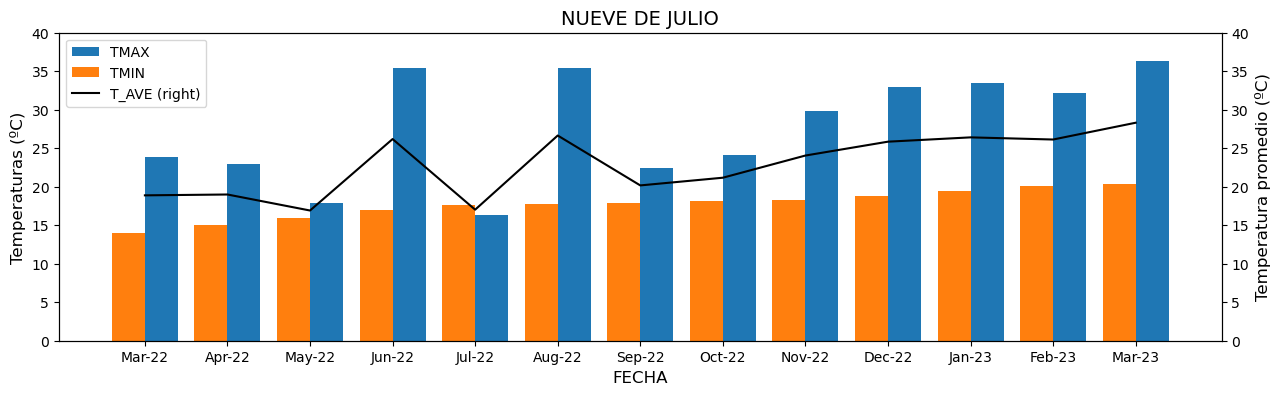

In [35]:
station1= pd.read_csv('station1_Avg.csv')

fig, ax=plt.subplots()

X= station1['FECHA']
TMAX = station1['TMAX']
TMIN = station1['TMIN']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, TMAX, 0.4, label = 'TMAX'), plt.ylim([0,40])
plt.bar(X_axis + 0.2, TMIN, 0.4, label = 'TMIN')
  
plt.xticks(X_axis, X), plt.xticks(rotation=45), plt.xlabel("Fechas", size=12), 
plt.ylabel("Temperaturas (ºC)", size=12), plt.legend()

station1.plot(x ='FECHA', y='T_AVE', ax = ax, secondary_y = True, color='Black', figsize=(15,4)),
ax.right_ax.set_ylabel('Temperatura promedio (ºC)', size=12),
plt.title("AEROPARQUE AERO", fontsize=14), plt.ylim([0,40]), ax.invert_xaxis(),plt.savefig("Station1_bars.png", dpi=300)
plt.show()


station2= pd.read_csv('station2_Avg.csv')
fig, ax=plt.subplots()
X= station2['FECHA']
TMAX = station2['TMAX']
TMIN = station2['TMIN']
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, TMAX, 0.4, label = 'TMAX'), plt.ylim([0,40])
plt.bar(X_axis + 0.2, TMIN, 0.4, label = 'TMIN')
plt.xticks(X_axis, X), plt.xticks(rotation=45), plt.xlabel("Fechas", size=12), plt.ylabel("Temperaturas (ºC)", size=12), plt.legend()
station2.plot(x ='FECHA', y='T_AVE', ax = ax, secondary_y = True, color='Black', figsize=(15,4)),ax.right_ax.set_ylabel('Temperatura promedio (ºC)', size=12) 
plt.xlabel("Fechas", size=12), plt.title("BUENOS AIRES OBSERVATORIO", fontsize=14), plt.ylim([0,40]), ax.invert_xaxis(),plt.savefig("Station2_bars.png", dpi=300)
plt.show()

station3= pd.read_csv('station3_Avg.csv')
fig, ax=plt.subplots()
X= station3['FECHA']
TMAX = station3['TMAX']
TMIN = station3['TMIN']
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, TMAX, 0.4, label = 'TMAX'), plt.ylim([0,40])
plt.bar(X_axis + 0.2, TMIN, 0.4, label = 'TMIN')
plt.xticks(X_axis, X), plt.xticks(rotation=45), plt.xlabel("Fechas", size=12), plt.ylabel("Temperaturas (ºC)", size=12), plt.legend()
station3.plot(x ='FECHA', y='T_AVE', ax = ax, secondary_y = True, color='Black', figsize=(15,4)),ax.right_ax.set_ylabel('Temperatura promedio (ºC)', size=12) 
plt.xlabel("Fechas", size=12), plt.title("EL PALOMAR AERO", fontsize=14), plt.ylim([0,40]), ax.invert_xaxis(),plt.savefig("Station3_bars.png", dpi=300)
plt.show()

station4= pd.read_csv('station4_Avg.csv')
fig, ax=plt.subplots()
X= station4['FECHA']
TMAX = station4['TMAX']
TMIN = station4['TMIN']
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, TMAX, 0.4, label = 'TMAX'), plt.ylim([0,40])
plt.bar(X_axis + 0.2, TMIN, 0.4, label = 'TMIN')
plt.xticks(X_axis, X), plt.xticks(rotation=45), plt.xlabel("Fechas", size=12), plt.ylabel("Temperaturas (ºC)", size=12), plt.legend()
station4.plot(x ='FECHA', y='T_AVE', ax = ax, secondary_y = True, color='Black', figsize=(15,4)),ax.right_ax.set_ylabel('Temperatura promedio (ºC)', size=12) 
plt.xlabel("Fechas", size=12), plt.title("MORON AERO", fontsize=14), plt.ylim([0,40]), ax.invert_xaxis(),plt.savefig("Station4_bars.png", dpi=300)
plt.show()

station5= pd.read_csv('station5_Avg.csv')
fig, ax=plt.subplots()
X= station5['FECHA']
TMAX = station5['TMAX']
TMIN = station5['TMIN']
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, TMAX, 0.4, label = 'TMAX'), plt.ylim([0,40])
plt.bar(X_axis + 0.2, TMIN, 0.4, label = 'TMIN')
plt.xticks(X_axis, X), plt.xticks(rotation=45), plt.xlabel("Fechas", size=12), plt.ylabel("Temperaturas (ºC)", size=12), plt.legend()
station5.plot(x ='FECHA', y='T_AVE', ax = ax, secondary_y = True, color='Black', figsize=(15,4)),ax.right_ax.set_ylabel('Temperatura promedio (ºC)', size=12) 
plt.xlabel("Fechas", size=12), plt.title("NUEVE DE JULIO", fontsize=14), plt.ylim([0,40]), ax.invert_xaxis(),plt.savefig("Station5_bars.png", dpi=300)
plt.show()

In [36]:
data_folder = Path(".") 
provincia = gpd.read_file (data_folder / 'provincia_buenos_aires.shp')

In [37]:
estaciones = pd.read_csv (data_folder / 'estaciones_smn.csv', sep= ";")

In [38]:
provincia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
estaciones.head()

Nombre     lat   long
0      AEROPARQUE AERO -34.560 -58.41
1      EL PALOMAR AERO -34.600 -58.61
2           MORON AERO -34.601 -58.63
3  NUEVE DE JULIO AERO -35.430 -60.88

In [40]:
lat = estaciones.lat
lon = estaciones.long
est = estaciones.Nombre

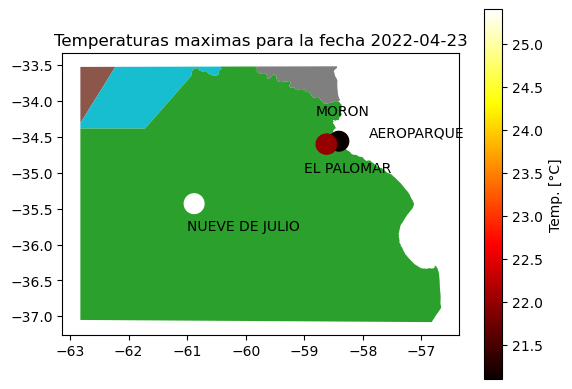

In [41]:
dia = "2022-04-23"
filtro_dia = dataset_temperatura['FECHA'] == dia
filtro_dato =( (filtro_dia & filtro_aeroparque) + (filtro_dia & filtro_moron) + (filtro_dia & filtro_9_julio) +
              (filtro_dia & filtro_palomar))
tmax = dataset_temperatura[filtro_dato].TMAX

provincia.plot(column='FNA', linewidth = 4)#, alpha= 0.5)#linecolor= 'b')
plt.scatter(lon,lat,
          c=tmax,s=200,
          cmap='hot', alpha=1)
#create colorbar 
plt.colorbar(label=r'Temp. [°C]')
plt.text(-61,-35.8, "NUEVE DE JULIO")
plt.text(-59,-35, "EL PALOMAR")
plt.text(-58.8,-34.2, "MORON")
plt.text(-57.9,-34.5, "AEROPARQUE")
plt.title("Temperaturas maximas para la fecha " + dia)
plt.show()

## seccion II

In [42]:
import xarray as xr
import geopandas as gpd
import os

import planetary_computer 
import pystac_client
import odc.stac

import matplotlib.pyplot as plt

import numpy as np

import rasterio.features

from pathlib import Path


In [72]:
bbox_of_interest = [-61.07,-35.62 , -58.15 , -34.31 ]

time_of_interest = "2023-01-01/2023-03-01"

In [73]:
os.environ['PC_SDK_SUBSCRIPTION_KEY'] = '2bb1ce5c4d8944d48b4129b9215ef932'  
# Always set this when reading from URLs
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR'

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 26 Items


In [74]:
ds = odc.stac.stac_load(
    items, 
    bands = ["nir08", "red"],
    bbox=bbox_of_interest,
    crs="utm",
    resolution=250, # units of output CRS (UTM)
    groupby='year', # adjacent acquisition frames automatically merged
    chunks={}, # Use Dask library to divy up large dataset!
)

In [75]:
ds

<xarray.Dataset>
Dimensions:      (y: 610, x: 1083, time: 1)
Coordinates:
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2023-01-02T13:45:05.253449
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 610, 1083), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 610, 1083), meta=np.ndarray>

In [76]:
ndvi = (ds.nir08 - ds.red) / (ds.nir08 + ds.red)

ndvi

<xarray.DataArray (time: 1, y: 610, x: 1083)>
dask.array<truediv, shape=(1, 610, 1083), dtype=float64, chunksize=(1, 610, 1083), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
    spatial_ref  int32 32721
  * time         (time) datetime64[ns] 2023-01-02T13:45:05.253449

In [77]:
ndvi = ndvi.compute()

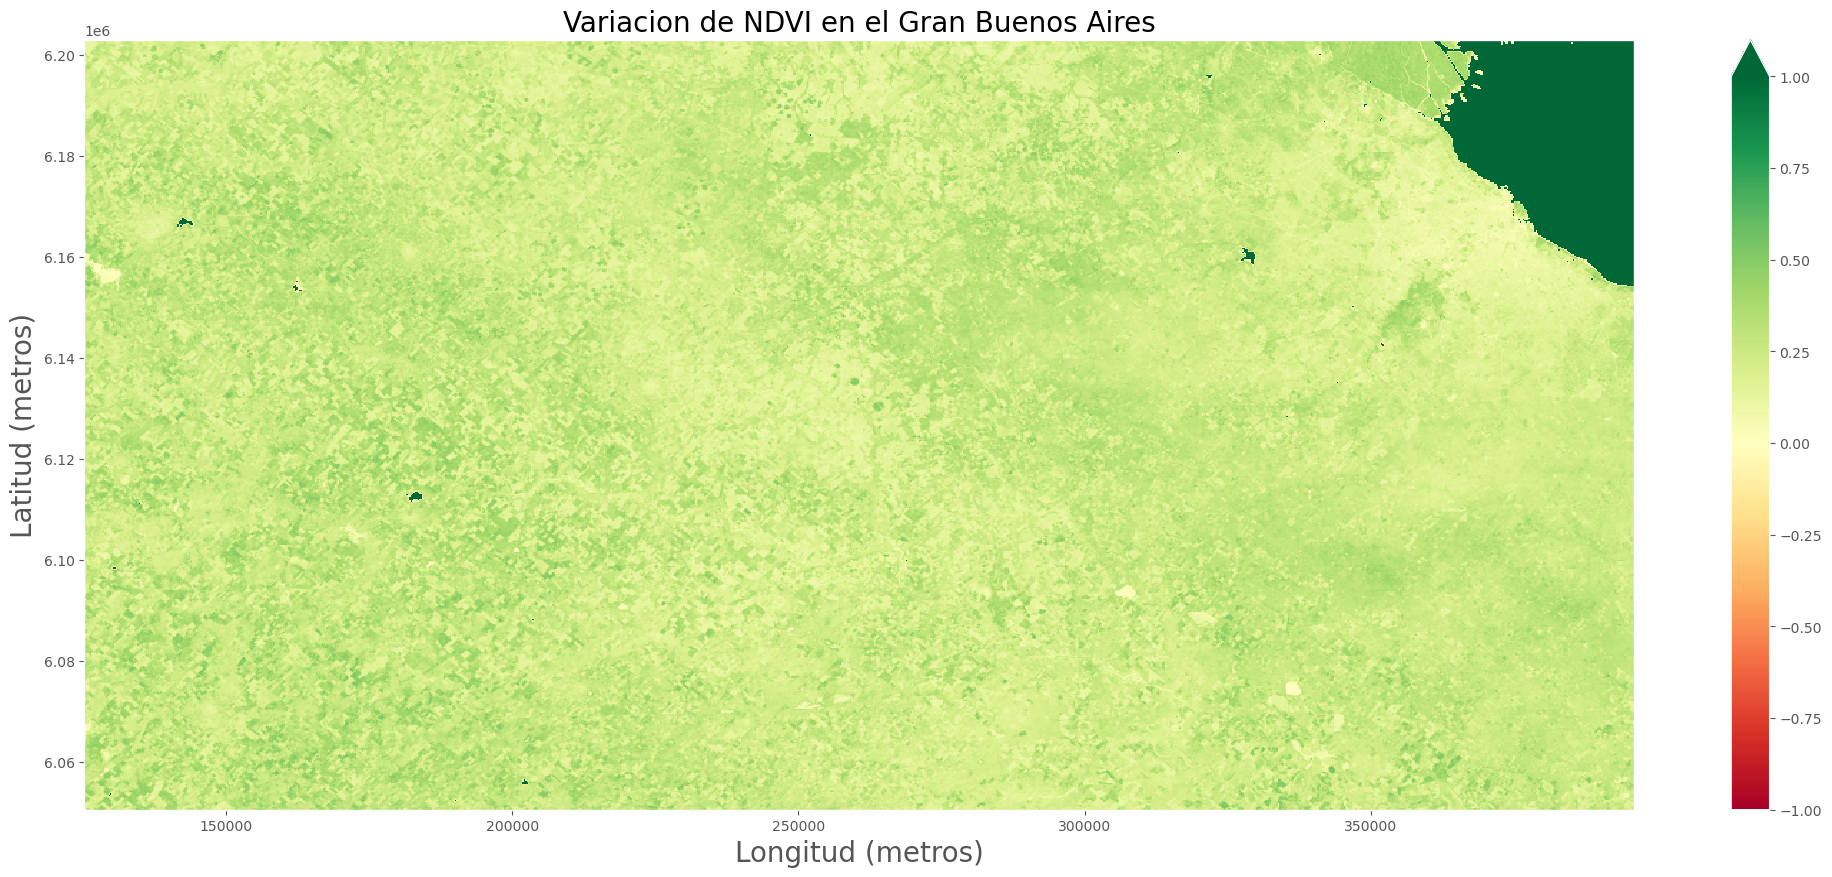

In [83]:
ndvi.isel(time=slice(0,1)).plot(vmin=-1, vmax=1, cmap='RdYlGn', label = "NDVI");
plt.xlabel('Longitud (metros)',fontsize=20)
plt.ylabel('Latitud (metros)',fontsize=20)
plt.title("Variacion de NDVI en el Gran Buenos Aires",fontsize=20)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()


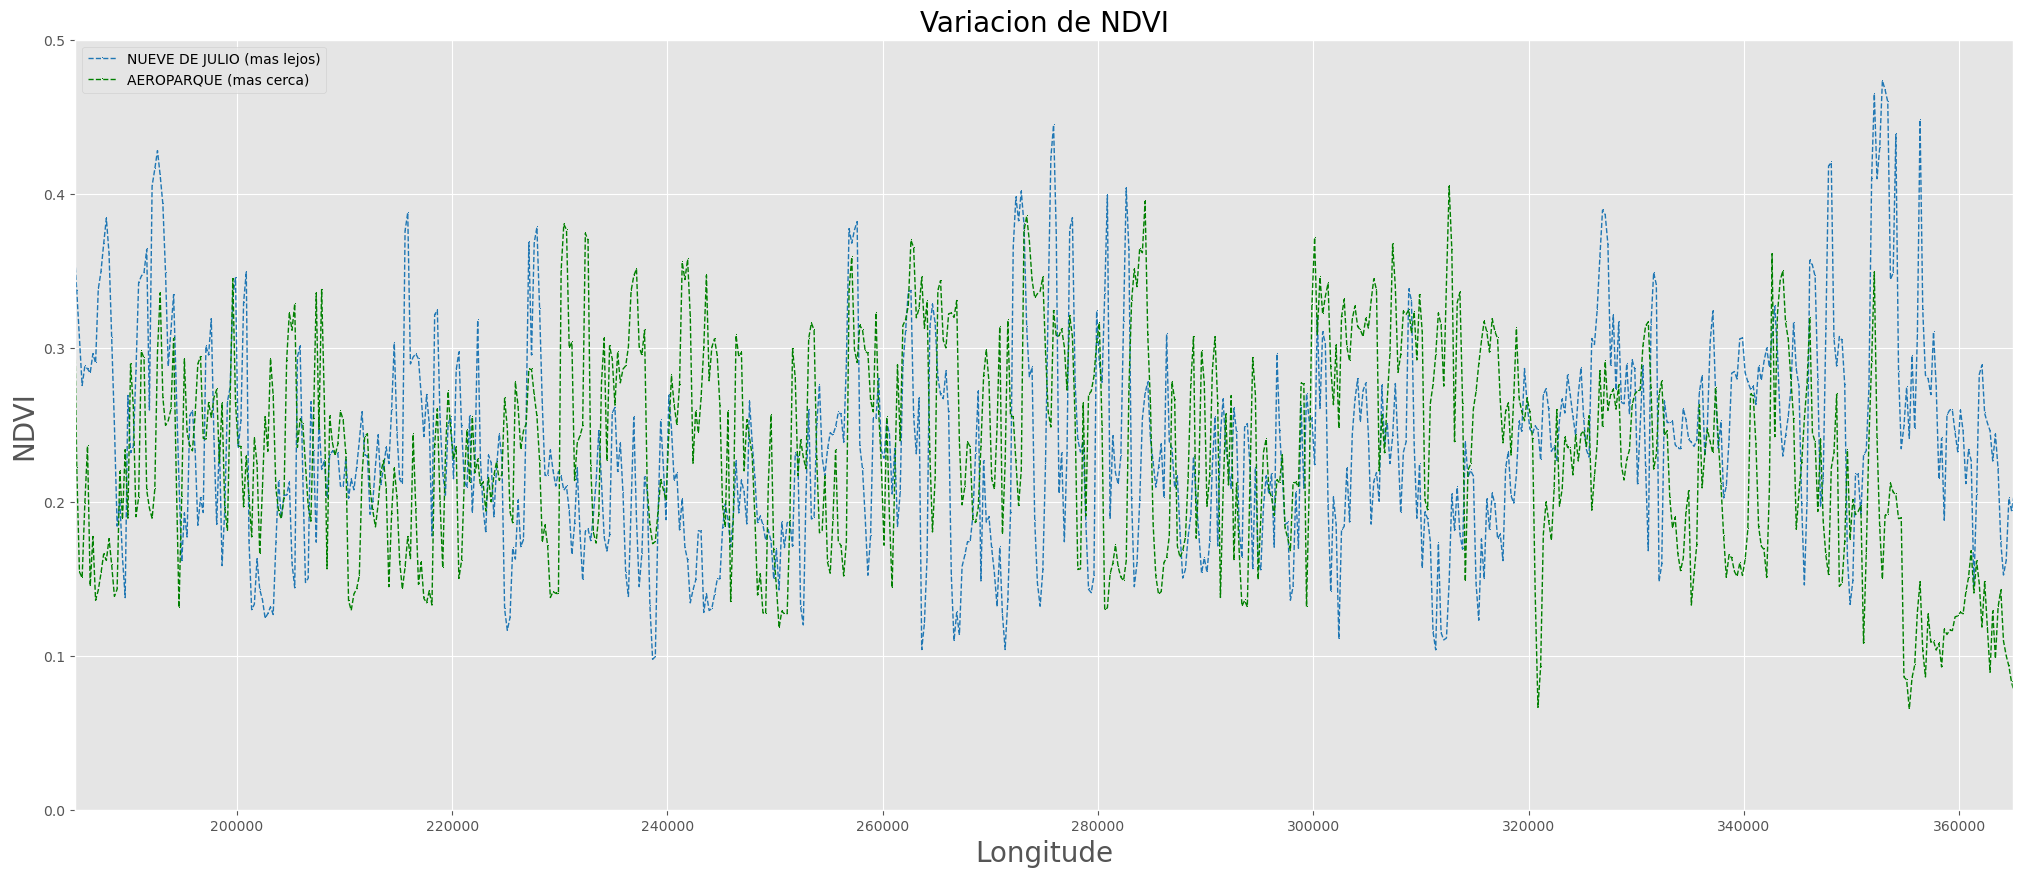

In [86]:
# Extract a profile (best in UTM for x-axis in meters)
plt.style.use('ggplot')
ndvi.sel(y=6080000, method='nearest').plot(color='#1f77b4', marker=',', linestyle='dashed',
     linewidth=1, markersize=25,label="NUEVE DE JULIO (mas lejos)")
ndvi.sel(y=6170000, method='nearest').plot(color='green', marker=',', linestyle='dashed',
     linewidth=1, markersize=25, label= "AEROPARQUE (mas cerca)")
plt.ylim(0, 0.5)
plt.xlim(185000, 365000)
plt.legend()
plt.xlabel('Longitude',fontsize=20)
plt.ylabel('NDVI',fontsize=20)
plt.title("Variacion de NDVI",fontsize=20)
plt.rcParams["figure.figsize"] = (25,10)
plt.show()

In [91]:
ndvi = Path(".") / "ndvi.tif"

In [92]:
ndvi = xr.open_dataarray(
    ndvi, 
    engine='rasterio',
)

ndvi

<xarray.DataArray 'band_data' (band: 1, y: 610, x: 1083)>
[660630 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.254e+05 1.256e+05 ... 3.956e+05 3.959e+05
  * y            (y) float64 6.203e+06 6.203e+06 ... 6.051e+06 6.051e+06
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area

In [93]:
estaciones2 = pd.read_csv (data_folder / 'estaciones_utm.csv', sep= ";")

In [94]:
estaciones2

Nombre       x        y
0      AEROPARQUE AERO  375000  6170000
1      EL PALOMAR AERO  350000  6160000
2           MORON AERO  355000  6160000
3  NUEVE DE JULIO AERO  175000  6080000

In [95]:
lat = estaciones2.x
lon = estaciones2.y
est = estaciones2.Nombre

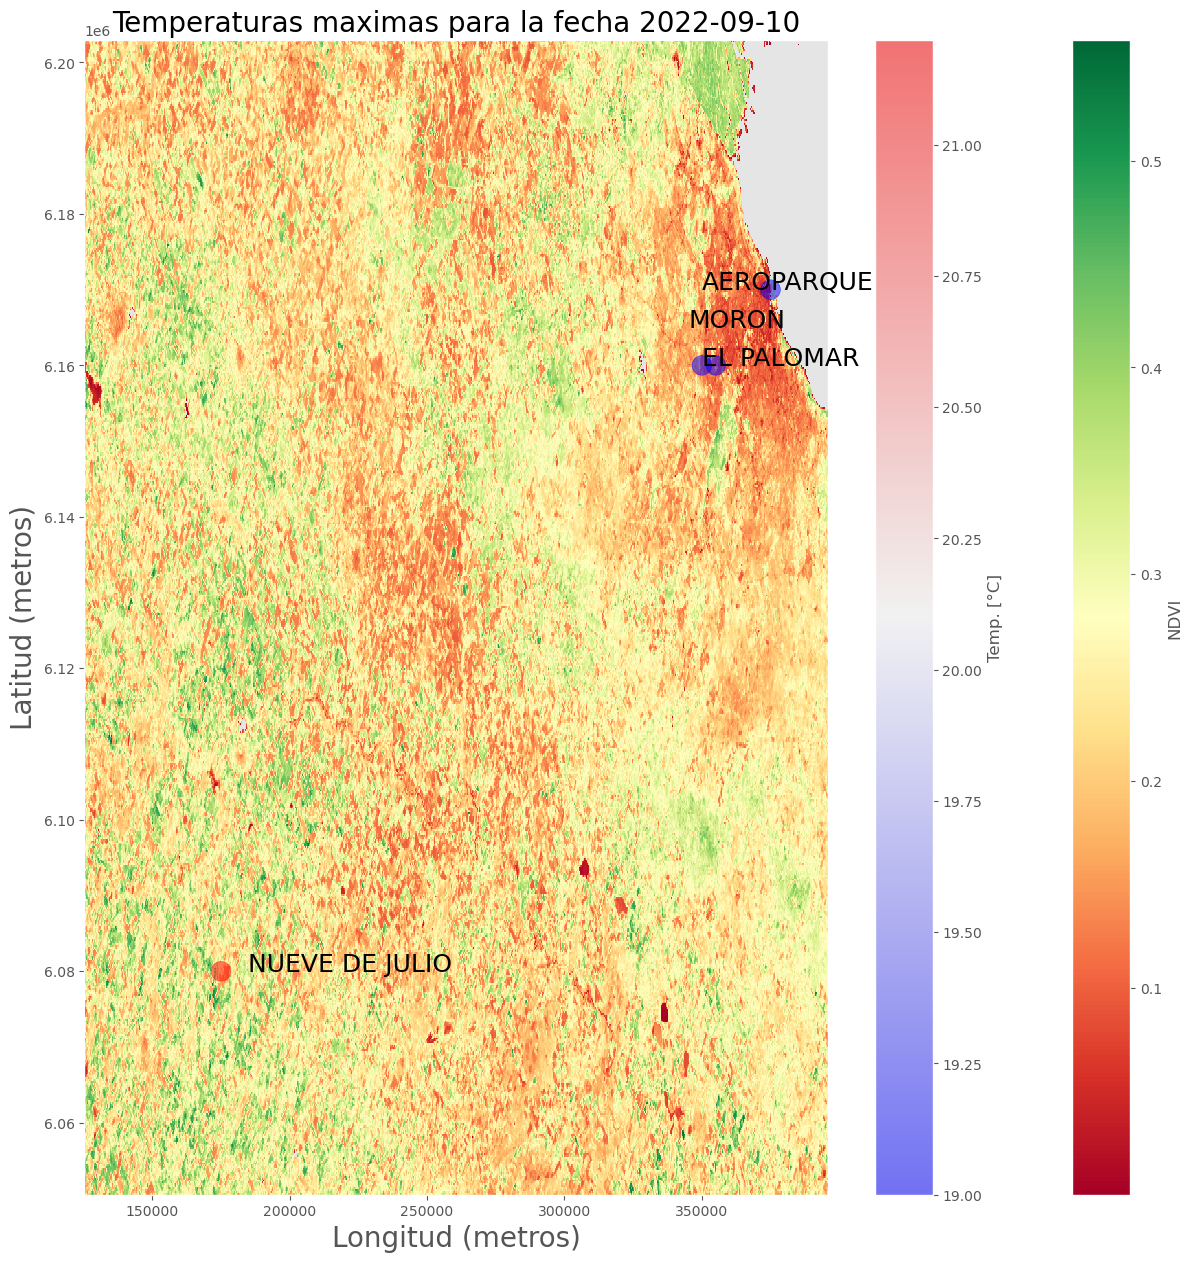

In [107]:
dia = "2022-09-10"
filtro_dia = dataset_temperatura['FECHA'] == dia
filtro_dato =( (filtro_dia & filtro_aeroparque) + (filtro_dia & filtro_moron) + (filtro_dia & filtro_9_julio) +
              (filtro_dia & filtro_palomar))
tmax = dataset_temperatura[filtro_dato].TMAX

ndvi.where(ndvi<1.01).squeeze().plot(cbar_kwargs={'label': "NDVI"},cmap="RdYlGn")

ax = plt.scatter(lat,lon,
          c=tmax,s=200,
          cmap='bwr', alpha=0.5)
#create colorbar 
plt.colorbar(label=r'Temp. [°C]')
plt.text(185000,6080000, "NUEVE DE JULIO",  fontsize=18)
plt.text(350000,6160000, "EL PALOMAR",fontsize=18)
plt.text(345000,6165000, "MORON",fontsize=18)
plt.text(350000, 6170000, "AEROPARQUE",fontsize=18)
plt.title("Temperaturas maximas para la fecha " + dia, fontsize=20 )
plt.xlabel('Longitud (metros)',fontsize=20)
plt.ylabel('Latitud (metros)',fontsize=20)
plt.rcParams["figure.figsize"] = (15,15)
plt.show()



In [129]:
tmax

22609    19.0
22641    19.0
22672    19.0
22674    21.2
Name: TMAX, dtype: float64

In [130]:
estaciones2

Nombre       x        y
0      AEROPARQUE AERO  375000  6170000
1      EL PALOMAR AERO  350000  6160000
2           MORON AERO  355000  6160000
3  NUEVE DE JULIO AERO  175000  6080000